In [2]:
# ---- CEDAR EDA (Notebook version: inline plots, no file saving, no CSVs) ----
import re
from pathlib import Path

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# 1) Paths (EDIT if needed)
DATA_ROOT = Path(r"W:\SRH study\Case Study 2\Offline Signature Verification\Datasets\signatures")
ORG_DIR  = DATA_ROOT / "full_org"
FORG_DIR = DATA_ROOT / "full_forg"

print("ORG exists:", ORG_DIR.exists(), "|", ORG_DIR)
print("FORG exists:", FORG_DIR.exists(), "|", FORG_DIR)

# 2) Filename patterns
PAT_ORG  = re.compile(r"^original_(\d+)_(\d+)\.png$", re.IGNORECASE)
PAT_FORG = re.compile(r"^forgeries_(\d+)_(\d+)\.png$", re.IGNORECASE)

def build_metadata():
    rows = []

    def scan(folder: Path, label: str, pat: re.Pattern):
        if not folder.exists():
            return
        for fp in folder.iterdir():
            if not fp.is_file():
                continue
            if fp.suffix.lower() != ".png":
                continue

            m = pat.match(fp.name)
            if not m:
                rows.append({
                    "writer_id": None,
                    "sample_id": None,
                    "label": label,
                    "path": str(fp),
                    "filename_ok": False
                })
                continue

            rows.append({
                "writer_id": int(m.group(1)),
                "sample_id": int(m.group(2)),
                "label": label,  # "genuine" or "forgery"
                "path": str(fp),
                "filename_ok": True
            })

    scan(ORG_DIR,  "genuine", PAT_ORG)
    scan(FORG_DIR, "forgery", PAT_FORG)

    return pd.DataFrame(rows)

df = build_metadata()

if df.empty:
    raise RuntimeError(
        "No files found. Double-check DATA_ROOT and that images end with .png/.PNG."
    )

print("\nTotal files found:", len(df))
print("Bad filenames:", (~df["filename_ok"]).sum())
display(df.head(10))

valid = df[df["filename_ok"]].copy()
print("\nCounts per label:")
display(valid["label"].value_counts())

print("\nUnique writers:", valid["writer_id"].nunique())
print("Writer id range:", (valid["writer_id"].min(), valid["writer_id"].max()))


ORG exists: True | W:\SRH study\Case Study 2\Offline Signature Verification\Datasets\signatures\full_org
FORG exists: True | W:\SRH study\Case Study 2\Offline Signature Verification\Datasets\signatures\full_forg

Total files found: 2640
Bad filenames: 0


,writer_id,sample_id,label,path,filename_ok
0,10,1,genuine,W:\SRH study\Case Study 2\Offline Signature Ve...,True
1,10,10,genuine,W:\SRH study\Case Study 2\Offline Signature Ve...,True
2,10,11,genuine,W:\SRH study\Case Study 2\Offline Signature Ve...,True
3,10,12,genuine,W:\SRH study\Case Study 2\Offline Signature Ve...,True
4,10,13,genuine,W:\SRH study\Case Study 2\Offline Signature Ve...,True
5,10,14,genuine,W:\SRH study\Case Study 2\Offline Signature Ve...,True
6,10,15,genuine,W:\SRH study\Case Study 2\Offline Signature Ve...,True
7,10,16,genuine,W:\SRH study\Case Study 2\Offline Signature Ve...,True
8,10,17,genuine,W:\SRH study\Case Study 2\Offline Signature Ve...,True
9,10,18,genuine,W:\SRH study\Case Study 2\Offline Signature Ve...,True



Counts per label:


label
genuine    1320
forgery    1320
Name: count, dtype: int64


Unique writers: 55
Writer id range: (np.int64(1), np.int64(55))


One image shape: (385, 534) | dtype: uint8


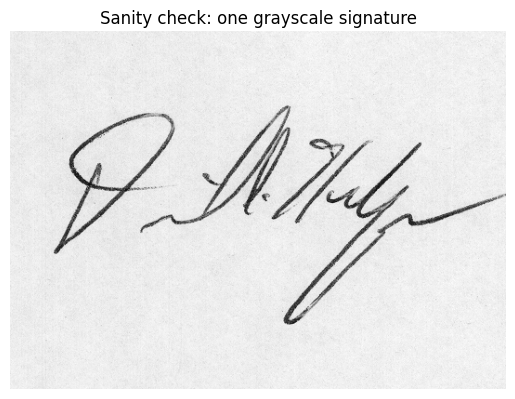

In [3]:
# ---- Image reading + binarization helpers ----

def read_gray(path: str) -> np.ndarray:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Could not read: {path}")
    return img

def otsu_ink_mask(gray: np.ndarray) -> np.ndarray:
    """
    Returns ink mask (foreground=1, background=0) using Otsu.
    Assumes ink is darker than background.
    """
    _, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    ink = (bw == 0).astype(np.uint8)  # dark pixels become ink=1
    return ink

# quick sanity check on 1 image
test_img = read_gray(valid.iloc[0]["path"])
print("One image shape:", test_img.shape, "| dtype:", test_img.dtype)
plt.figure()
plt.imshow(test_img, cmap="gray")
plt.axis("off")
plt.title("Sanity check: one grayscale signature")
plt.show()


In [4]:
# ---- Compute image-level stats: size + intensity + ink density ----
records = []
for p in valid["path"].values:
    g = read_gray(p)
    h, w = g.shape
    ink = otsu_ink_mask(g)
    records.append({
        "path": p,
        "height": h,
        "width": w,
        "min": int(g.min()),
        "max": int(g.max()),
        "mean": float(g.mean()),
        "std": float(g.std()),
        "ink_density": float(ink.mean())  # fraction of pixels classified as ink
    })

stats = pd.DataFrame(records)
valid = valid.merge(stats, on="path", how="left")

print("Top (height,width) sizes:")
display(
    valid.groupby(["height","width"]).size().sort_values(ascending=False).head(10).to_frame("count")
)

print("\nInk density summary:")
display(valid["ink_density"].describe())


Top (height,width) sizes:


count
height width       
384    594        6
366    504        6
396    564        5
294    618        5
396    588        5
372    612        5
360    570        5
372    594        5
       618        5
354    594        5


Ink density summary:


count    2640.000000
mean        0.035263
std         0.013807
min         0.010223
25%         0.025086
50%         0.033046
75%         0.042713
max         0.104598
Name: ink_density, dtype: float64

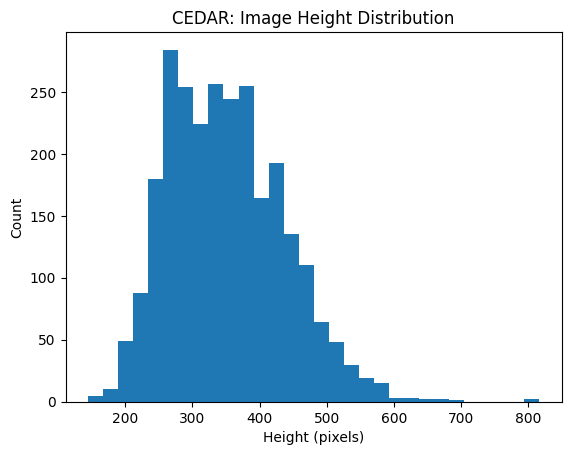

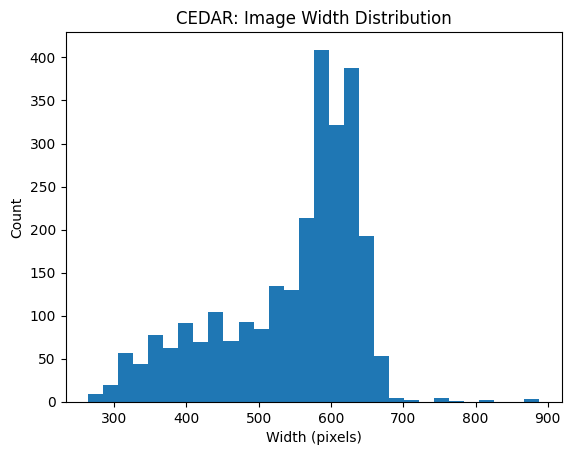

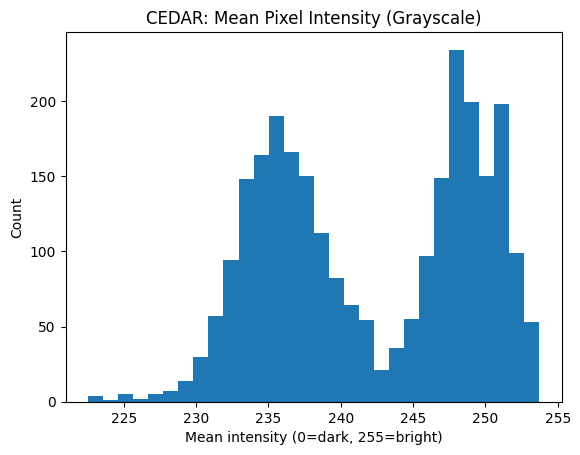

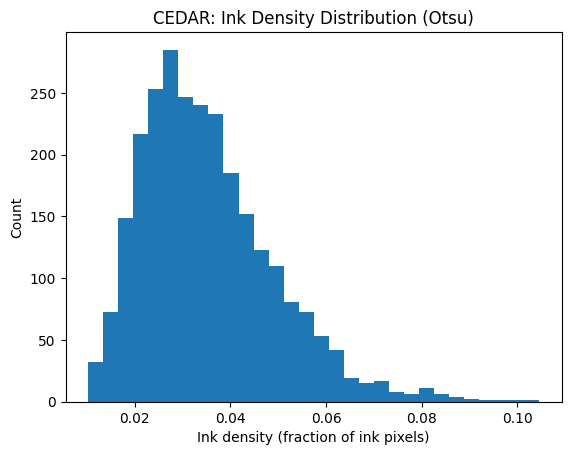

C:\Users\91900\AppData\Local\Temp\ipykernel_1464\1722025647.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=["genuine", "forgery"])


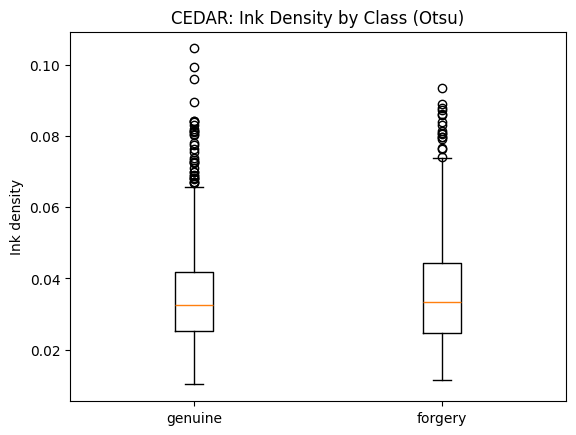

In [5]:
# ---- Inline plots (no saving) ----

plt.figure()
plt.hist(valid["height"], bins=30)
plt.title("CEDAR: Image Height Distribution")
plt.xlabel("Height (pixels)")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.hist(valid["width"], bins=30)
plt.title("CEDAR: Image Width Distribution")
plt.xlabel("Width (pixels)")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.hist(valid["mean"], bins=30)
plt.title("CEDAR: Mean Pixel Intensity (Grayscale)")
plt.xlabel("Mean intensity (0=dark, 255=bright)")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.hist(valid["ink_density"], bins=30)
plt.title("CEDAR: Ink Density Distribution (Otsu)")
plt.xlabel("Ink density (fraction of ink pixels)")
plt.ylabel("Count")
plt.show()

# Compare genuine vs forgery ink density
plt.figure()
data = [
    valid.loc[valid["label"] == "genuine", "ink_density"].values,
    valid.loc[valid["label"] == "forgery", "ink_density"].values
]
plt.boxplot(data, labels=["genuine", "forgery"])
plt.title("CEDAR: Ink Density by Class (Otsu)")
plt.ylabel("Ink density")
plt.show()


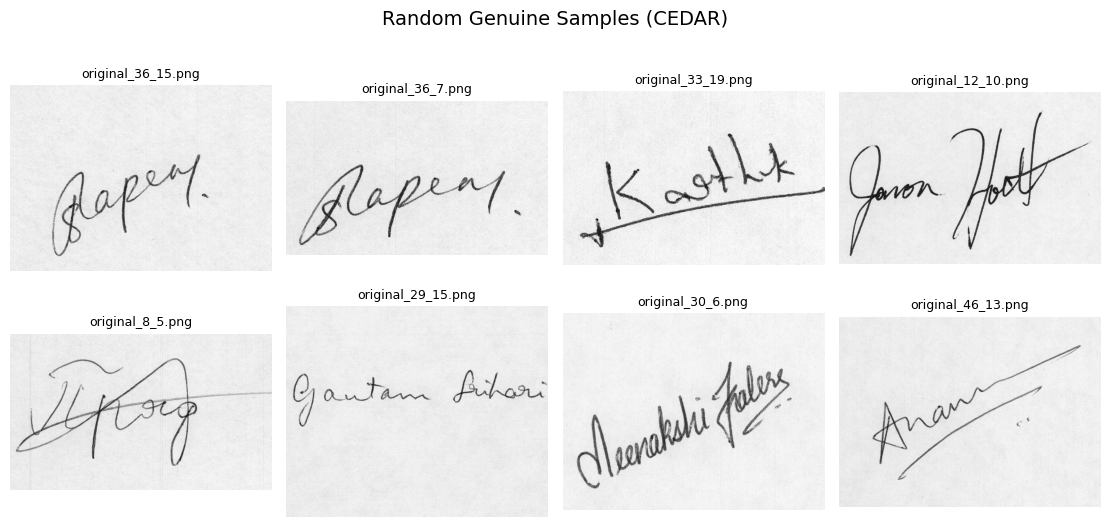

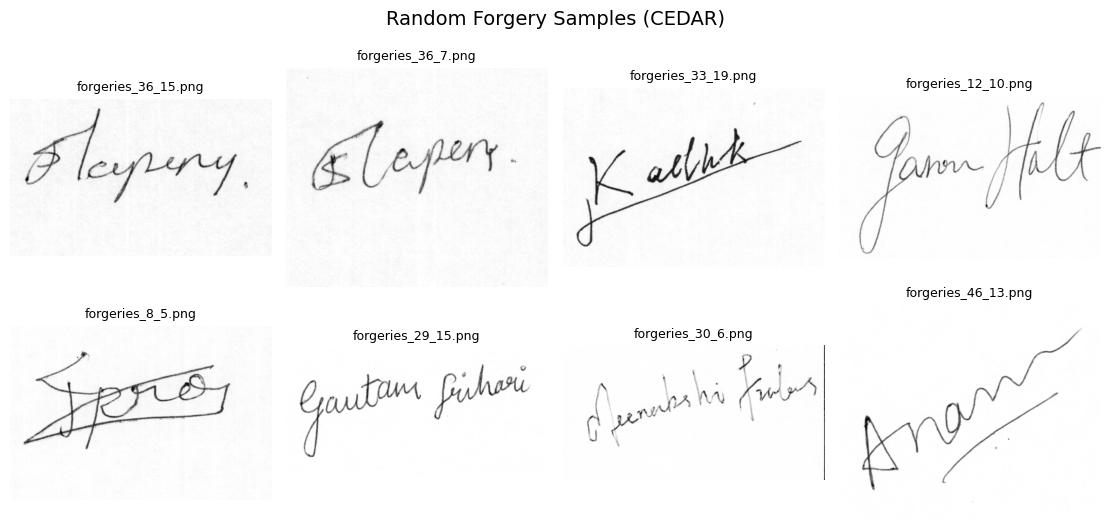

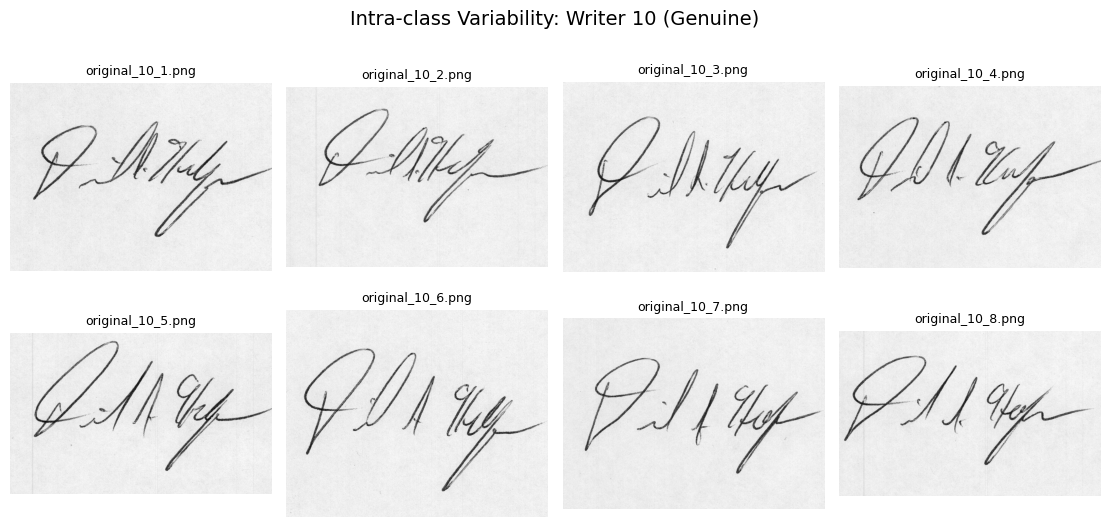

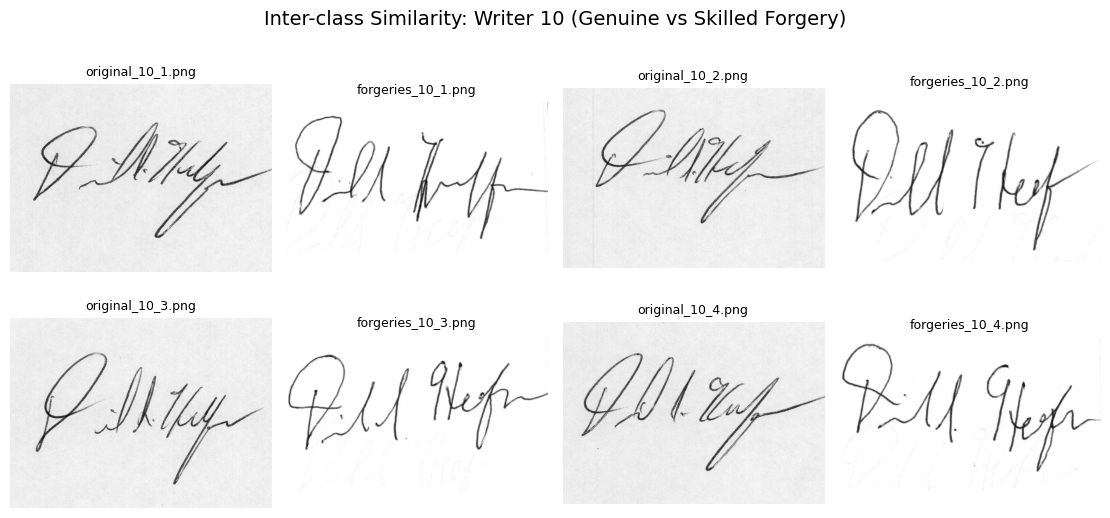

In [6]:
# ---- Visual grids: random samples, intra-class variability, genuine vs forgery ----

def show_grid(image_paths, nrows, ncols, title, preprocess=None):
    plt.figure(figsize=(2.8*ncols, 2.8*nrows))
    for i, p in enumerate(image_paths[: nrows*ncols]):
        img = read_gray(p)
        if preprocess is not None:
            img = preprocess(img)
        ax = plt.subplot(nrows, ncols, i+1)
        ax.imshow(img, cmap="gray")
        ax.axis("off")
        ax.set_title(Path(p).name, fontsize=9)
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Random genuine + random forgery
sample_g = valid[valid["label"] == "genuine"].sample(8, random_state=42)["path"].tolist()
sample_f = valid[valid["label"] == "forgery"].sample(8, random_state=42)["path"].tolist()

show_grid(sample_g, 2, 4, "Random Genuine Samples (CEDAR)")
show_grid(sample_f, 2, 4, "Random Forgery Samples (CEDAR)")

# Intra-class variability: multiple genuine from same writer
writer_pick = int(valid["writer_id"].dropna().unique()[0])  # change e.g., 1, 10, 25...
same_writer_g = (
    valid[(valid["writer_id"] == writer_pick) & (valid["label"] == "genuine")]
    .sort_values("sample_id")["path"].tolist()
)
show_grid(
    same_writer_g, 2, 4,
    f"Intra-class Variability: Writer {writer_pick} (Genuine)"
)

# Inter-class similarity: show pairs (genuine vs forgery) for same writer by same sample_id
gw = valid[(valid["writer_id"] == writer_pick) & (valid["label"] == "genuine")][["sample_id","path"]]
fw = valid[(valid["writer_id"] == writer_pick) & (valid["label"] == "forgery")][["sample_id","path"]]
paired = gw.merge(fw, on="sample_id", suffixes=("_genuine", "_forgery")).sort_values("sample_id")

pairs_list = []
for _, r in paired.head(4).iterrows():  # 4 pairs -> 8 images
    pairs_list.append(r["path_genuine"])
    pairs_list.append(r["path_forgery"])

show_grid(
    pairs_list, 2, 4,
    f"Inter-class Similarity: Writer {writer_pick} (Genuine vs Skilled Forgery)"
)


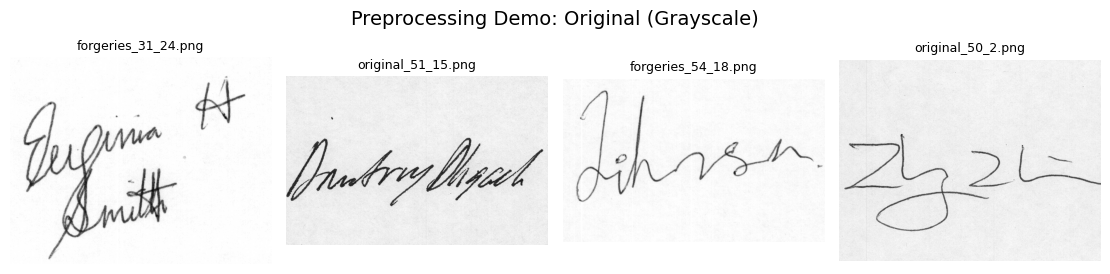

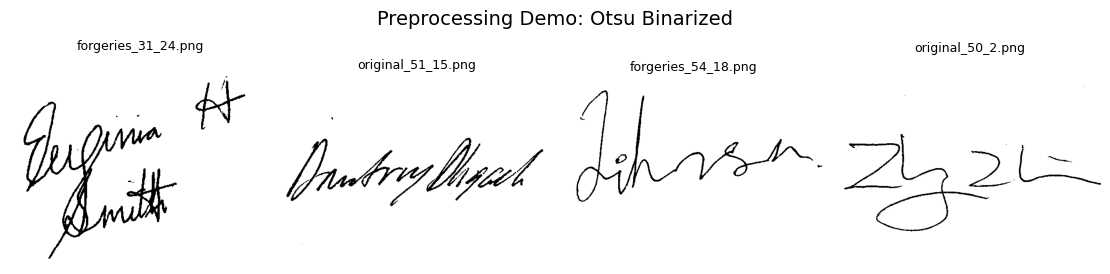

In [7]:
# ---- Preprocessing demo: original vs Otsu-binarized (ink mask) ----

demo_paths = valid.sample(4, random_state=7)["path"].tolist()

show_grid(demo_paths, 1, 4, "Preprocessing Demo: Original (Grayscale)")

def binarized_for_display(gray):
    ink = otsu_ink_mask(gray) * 255
    # Display ink as dark: convert ink mask to "signature-like" image
    return 255 - ink

show_grid(demo_paths, 1, 4, "Preprocessing Demo: Otsu Binarized", preprocess=binarized_for_display)
